# Homework 3:  Softmax Regression 

<span style="font-size: 20px;">Welcome to the course  **AI and Deep Learning**!</span>


Since you have mastered the Logistic Regression, now Let's move on to the generalization of logistic regression to multiple classes---softmax regression. It is used for classification problems where the target variable has more than two possible classes.The key function in softmax regression is the **softmax function**,which converts the raw model outputs(logits) into probabilities that sum up to one.As a fundation for categorical data analysis , softmax regression is of great importance in both statistics and deep learning. In homework3 , we would use simulation again to review softmax regression in more details.Hope you enjoy the third homework!

**Learning Goal:** In this homework, we are going to conduct a simple simulation study based on a softmax regression.After this homework, you will know:

<style>
ul li {
  list-style-type: disc;
  padding-left: 20px;
}
</style>

<ul>
  <li>How to implement a softmax function </li>
  <li>How to construct the loss function for softmax regression </li> 
  <li>How to compute the gradients for the softmax output layer during backpropagation </li>
  <li>How to evaluate the classification precision</li>
</ul>

# Table of content

<style>
ol li {
  list-style-type: decimal-leading-zero;
  padding-left: 20px;
}
</style>

<ol>
  <li>Packages</li>
  <li>Generate a training dataset</li>
  <li>softmax function
    <ol style="list-style-type:lower-alpha;">
      <li>Sum operator</li>
      <li>Broadcasting mechanism</li>
      <li>Steps for building a softmax function</li>
    </ol>
  </li>
  <li>Cross-Entropy Loss function</li> 
    <ol style="list-style-type:lower-alpha;">
      <li>relationship between MLE and cross entropy</li>
      <li>CE function</li>
     </ol>
  </li>  
  <li>Gradients of the softmax layer</li>
    <ol style="list-style-type:lower-alpha;">
      <li>forward propogation</li>
      <li>backward propogation</li>
      <li>update parameters</li>
     </ol>
  </li>  
  <li>Classification Precision</li>
  <li>Complete process</li>
    <ol style="list-style-type:lower-alpha;">
      <li>softmax regression complete code pipeline</li>
      <li>a vivid example</li>
      <li>softmax regression concise implementation</li>
  </li> 
  
  
</ol>

# 1-Packages

In order to finish a task , we need commands from certain **Python** packages.Again, one of the commonly used package is **numpy**.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt # for plots
import torch.nn as nn
from torch.optim import SGD

# 2-Generate a multi-class training dataset 

First, we generate a training dataset from a pre-specified softmax regression model.**In order to guarantee that our simulation results are reproducible , we need to control the random seed.** That is , after controlling the seed , others can generate the **SAME** random variables as we did, so our simulation results can be reproduced.**Random seed is very important!**

In [ ]:
def generate_data(n_samples, n_features, n_classes, noise_std,random_seed):
    
    #n_samples: sample size
    #n_features: the dimension of each sample's features
    #n_classes: the number of distinct classes to which a sample can belong.
    #noise_std: the standard deviation added to the feature matrix
    #random_seed: you need to define your global random seed for reproducibility
    
    #step 1 :set random seed to be random_seed
    #step 2 : define true weight and bias , the dimension of weight matrix is (n_classes,n_features),the dimension of bias is(n_classes,)
    #step 3 : generate features using standard normal distribution,the size of the matrix is (n_samples,n_features)
    #step 4 : calculate probability distribution 
    #step 5 : generate labels sampling from the probability distribution
    #step 6:  Convert the class labels `y` (with shape `(n_samples,)`) into a one-hot encoded matrix (with shape `(n_samples, n_classes)`).
    
    ### YOUR CODE BEGINS HERE
    np.random.seed(random_seed)
    
    W_true = np.array([[2.0, -1.0], [-1.5, 1.0], [0.5, -0.8]])  # 3x2 weight matrix
    b_true = np.array([0.1, -0.2, 0.3])  
    
   
    X = np.random.randn(n_samples, n_features) 
    
   
    logits = X @ W_true.T + b_true  #broadcasting
    probabilities = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    
   
    y = np.array([np.random.choice(n_classes, p=p) for p in probabilities])
    y_onehot = np.eye(n_classes)[y.astype(np.int64)]
    
   
    X += np.random.normal(0, noise_std, size=X.shape)
    ### YOUR CODE ENDS
                   
    return X,  y_onehot





Visualize the generated data , you may want to run the following code.

C:\Windows\Temp\ipykernel_16804\1404432307.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolors='w')


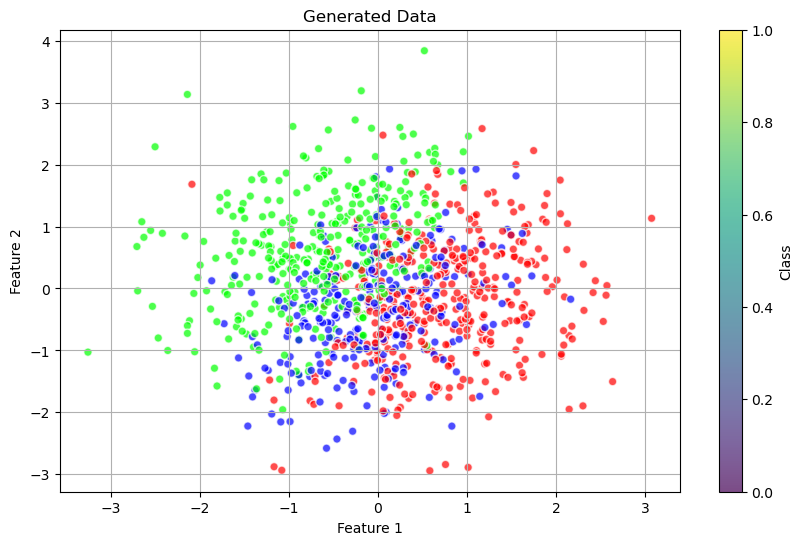

(array([[ 0.50244543, -0.15612297],
        [ 0.64409224,  1.52604093],
        [-0.23231503, -0.20720662],
        ...,
        [ 0.34879216,  1.06615146],
        [-0.02766767, -0.87923197],
        [-0.16456813, -0.75754271]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]]))

In [ ]:

def plot_2d_data(X, y, title="Generated Data"):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolors='w')
    plt.colorbar(scatter, label='Class')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.grid(True)
    plt.show()

X, y_onehot = generate_data(n_samples=1000, n_features=2, n_classes=3,noise_std=0.01, random_seed=42)
plot_2d_data(X, y_onehot)

X,y_onehot

# 3- softmax function


<span style="font-size: 20px;">**3.1 Sum operator**</span>


before realizing softmax regression, we need to briefly review how the **sum operator** work along a specific dimension in a tensor

here is a vivid example

In [ ]:
#the illustration of how the sum operator works

Z= torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])

#sum along dimension 0(dim=0)
Z.sum(0,keepdim=True)

tensor([[5., 7., 9.]])

dim=0 specifies that the summation should be performed along the rows (i.e., across columns).

keepdim=True ensures that the resulting tensor retains the same number of dimensions as the original tensor. 2D tensor

In [ ]:
#sum along dimension 1(dim=1)
Z.sum(1,keepdim=True)

tensor([[ 6.],
        [15.]])

dim=1 specifies that the summation should be performed along the columns (i.e., across rows).

keepdim=True ensures that the resulting tensor retains the same number of dimensions as the original tensor.2D tensor.


<span style="font-size: 20px;">**3.2 Broadcasting mechanism**</span>


**broadcasting mechanism** allows for arithmetic operations between arrays of **different shapes**. Here is a simple example using NumPy to illustrate the broadcasting mechanism:

In [ ]:
#broadcasting mechanism illustration

# Create a 2D array (matrix)
matrix = np.array([[1, 2, 3],
                   [4, 5, 6]])

# Create a 1D array (vector)
vector = np.array([10, 20, 30])

# Perform broadcasting: Add the vector to each row of the matrix
result = matrix + vector


print("Result of broadcasting (matrix + vector):\n", result)

Result of broadcasting (matrix + vector):
 [[11 22 33]
 [14 25 36]]


<span style="font-size: 20px;">**3.3 Steps for building a softmax function**</span>



1. Exponentiate each term (using `exp`).
2. Sum across each row (each sample is a row) to obtain the normalization constant for each sample.
3. Divide each row by its normalization constant to ensure the sum of the results equals 1.


$$
\text{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

In [ ]:
def softmax(X):
    
    ### YOUR CODE BEGINS HERE###
    X_exp = torch.exp(X)
    partition= X_exp.sum(1,keepdim=True)
    return X_exp / partition   #broadcasting

    ### YOUR CODE ENDS###

In [ ]:
#after defining the softmax operator, we can realize the softmax regression 

#initialize model parameters
n_classes=3
n_features=2

W=torch.normal(0,0.1,size=(n_features,n_classes),requires_grad=True, dtype=torch.float32)
b=torch.zeros(n_classes,requires_grad=True,dtype=torch.float32)

####YOUR CODE BEGINS HERE###
def net(X):
    return softmax(torch.matmul(X,W)+b)
###YOUR CODE ENDS HERE###

X_tensor = torch.tensor(X,dtype=torch.float32) # transfer the type of generated X from numpy to tensor
y_true =  torch.tensor(y_onehot,dtype=torch.long)

y_pred = net(X_tensor)


# 4-Cross-Entropy loss function

<span style="font-size: 20px;">**4.1 Relationship between MLE and cross entropy**</span>


**Indeed,CrossEntropy loss function is equivalent to the negative log-likelihood function.** Below is the illustration.

Consider a multi-class classification problem with $C$ classes. Let $\mathbf{X}$ be the input features and $\mathbf{Y}$ be the one-hot encoded target variable where $\mathbf{Y} \in \mathbb{R}^{C}$ and $\mathbf{Y}_{ic} = 1$ if class $c$ is the correct classification for observation $i$, and $0$ otherwise.

The predicted probabilities are given by applying the softmax function to the linear combination of the input features and weights:
$$
p(\mathbf{Y}|\mathbf{X}) = \text{softmax}(\mathbf{Z}) = \frac{\exp(\mathbf{Z})}{\sum_{k=1}^{C} \exp(\mathbf{Z}_k)}
$$
where $\mathbf{Z} = \mathbf{W}^T\mathbf{X} + \mathbf{b}$.

The likelihood of the observed data given the parameters is the product of the probabilities of each observation:
$$
L(\mathbf{W}, \mathbf{b}) = \prod_{i=1}^{N} \prod_{c=1}^{C} [p(\mathbf{Y}|\mathbf{X})]_{ic}^{y_{ic}}
$$
where $N$ is the number of observations.

Taking the log of the likelihood function to simplify the product into a sum gives us the log-likelihood:
$$
\ell(\mathbf{W}, \mathbf{b}) = \log L(\mathbf{W}, \mathbf{b}) = \sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log [p(\mathbf{Y}|\mathbf{X})]_{ic}
$$

The negative log-likelihood, which is the objective we typically minimize, is:
$$
-\ell(\mathbf{W}, \mathbf{b}) = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log [p(\mathbf{Y}|\mathbf{X})]_{ic}
$$

This is equivalent to the CrossEntropy loss function:
$$
H(\mathbf{p}, \mathbf{Y}) = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log p_{ic}
$$

where $p_{ic} = [p(\mathbf{Y}|\mathbf{X})]_{ic}$ is the predicted probability of class $c$ for observation $i$.

Thus, minimizing the CrossEntropy loss is equivalent to maximizing the log-likelihood, which is the Maximum Likelihood Estimation (MLE) principle.

<span style="font-size: 20px;">**4.2 Cross-Entropy loss function**</span>


In [ ]:
def cross_entropy_loss(y_pred, y_true):
    """
    Compute the cross-entropy loss.
    
    Parameters:
    y_pred (np.array): Predicted probabilities, shape (n_samples, n_classes)
    y_true (np.array): True labels, shape (n_samples,n_classes) 
    
    Returns:
    float: Cross-entropy loss
    """
    ### YOUR CODE BEGINS HERE
    return  -torch.sum(y_true * torch.log(y_pred),dim=1) 
    ### YOUR CODE ENDS HERE



The operation  **y_pred[range(len(y_true)), y]**  is used to extract the predicted probabilities corresponding to the true classes for each sample from y_pred. Specifically, for each sample, it uses the indices from range(len(y_hat)) to select the rows and then uses the indices from y to select the columns. 

# 5- Gradients of the softmax layer

<span style="font-size: 20px;">**5.1 Forward Propagation**</span>








**1.calculate logits**


$$
Z = X W^T + b \quad \text{其中} \quad Z \in \mathbb{R}^{n\_samples \times n\_classes}
$$

-
   $ Z $: original output after linear transformation



**2.calculate softmax probability**

$$
P = \text{softmax}(Z) = \left[ \frac{e^{Z_{ij}}}{\sum_{c=1}^k e^{Z_{ic}}} \right] \quad \text{其中} \quad P \in \mathbb{R}^{n\_samples \times n\_classes}
$$


  - 每行元素和为 1：每行元素和为 1：
$$
\sum_{j=1}^{n\_{\text{classes}}} P_{ij} = 1
$$
  - 指数运算保证 $ P_{ij} > 0 $
  


  **3.Loss function (Cross Entropy)**
$$
L = - \sum_{i=1}^{n\_samples} \sum_{j=1}^{n\_classes} Y_{ij} \log P_{ij}
$$





<span style="font-size: 20px;">**5.2 Backward Propogation**
</span>



**gradients for softmax：**
$$
\frac{\partial L}{\partial Z} = P - Y \quad ( \in \mathbb{R}^{n \times k} )
$$


Softmax 交叉熵梯度推导


对于单个样本 $ i $，其交叉熵损失为：

$$
L_i = -\sum_{c=1}^k Y_{i,c} \log P_{i,c} 
$$

其中：
- $ Y_{i,c} \in \{0,1\} $ 为 one-hot 编码的真实标签
- 每行有且仅有一个元素为 1（即 $ \sum_{c=1}^k Y_{i,c} = 1 $）




将 logits $ Z $ 转换为概率分布：

$$
P_{i,c} = \frac{e^{Z_{i,c}}}{\sum_{m=1}^k e^{Z_{i,m}}}
$$



需计算偏导数 $ \frac{\partial L_i}{\partial Z_{i,j}} $，分两种情况讨论：

 情况 1：$ j $ 是真实类别（$ Y_{i,j} = 1 $）
$$
\frac{\partial L_i}{\partial Z_{i,j}} = P_{i,j} - 1
$$

情况 2：$ j $ 不是真实类别（$ Y_{i,j} = 0 $）
$$
\frac{\partial L_i}{\partial Z_{i,j}} = P_{i,j}
$$



 统一表达式
合并两种情况可得：

$$
\frac{\partial L_i}{\partial Z_{i}} = P_{i} - Y_{i}
$$

推广到整个矩阵：

$$
\frac{\partial L}{\partial Z} = P - Y \quad \in \mathbb{R}^{n\_samples \times n\_classes}
$$

其中：
- $ P $: Softmax 输出的概率矩阵
- $ Y $: 真实标签的 one-hot 编码矩阵


   
   
   
   
   
   
   
   
   
   
   
   
   
   
gradients for W：  (the chain rule)
$$
\frac{\partial L}{\partial W} =  (P - Y)^T X \quad ( \in \mathbb{R}^{n\_classes \times n\_features} )
$$

gradients for b：  (the chain rule)
$$
\frac{\partial L}{\partial b} =  \sum_{i=1}^{n} (P_i - Y_i) \quad ( \in \mathbb{R}^{n\_classes} )
$$

In [ ]:
def compute_gradients(X,y_true,y_pred):
    #calculate the gradients toward W and b
    
    ###YOUR CODE BEGINS HERE###
    error = y_pred - y_true   # # ∂L/∂Z
    
    dW = error.T @ X
    db = np.sum(error, axis=0)
    
    return dW,db
   ###YOUR CODE ENDS HERE###

<span style="font-size: 20px;">**5.3 Update Parameters**</span>



In [ ]:
#using gradient descent method to update parameters

###YOUR CODE BEGINS HERE###
'''
W -= lr * dW
b -= lr * db

'''
###YOUR CODE ENDS HERE###

'\nW -= lr * dW\nb -= lr * db\n\n'

# 6- Classification Precision


Given a predicted probability distribution y_pred, when we need to output a hard prediction, we typically select the class with the highest predicted probability. This process is known as taking the **"argmax"** of the probability distribution.


When predictions match the true labels y, they are considered correct. **Classification accuracy is the ratio of the number of correct predictions to the total number of predictions made.**  Although it can be challenging to directly optimize for accuracy (since the calculation of accuracy is not differentiable), accuracy is often the performance metric we care about the most, and we almost always pay attention to it when training classifiers.

In [ ]:
def accuracy(y_pred, y_true):  
    ###YOUR CODE BEGINS HERE###
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
    cmp = y_pred.type(y_true.dtype) == y_true
    return float(cmp.type(y.dtype).sum())

# accuracy(y_pred, y_true) / len(y_true)
    ###YOUR CODE ENDS HERE###

# 7-Complete process

<span style="font-size: 20px;">**7.1 softmax regression complete code pipeline**</span>



In [ ]:
class SoftmaxRegression:
   ###1.initialiazation:set parameters
   ###2.forward propagation 
   ###3.loss function
   ###4.update parameters
   ###5.predition


    ###YOUR CODE BEGINS HERE###

    def __init__(self, lr=0.01, epochs=100, reg_lambda=0.01,verbose=True):
        """
        Parameters:
            lr: learning rate
            epochs: 迭代次数
            reg_lambda: L2 regularization coefficient,in case of overfitting(optional)
            verbose:Whether to print training information
        """
        self.lr = lr
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.verbose = verbose

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        # Initialize parameters
        self.W = np.random.randn(n_classes, n_features) * 0.01
        self.b = np.zeros(n_classes)
        
        
        y_onehot = np.eye(n_classes)[y]
        
        self.loss_history=[]

        for _ in range(self.epochs):
            # forward propogation
            logits = X @ self.W.T + self.b
            probs = self._softmax(logits)
            
            # calculate the loss function（L2 regularization）
            loss = self._cross_entropy_loss(probs, y_onehot)
            reg_loss = 0.5 * self.reg_lambda * np.sum(self.W**2)
            total_loss = loss + reg_loss
            self.loss_history.append(total_loss)
            
            
            # backward propogation
            error = probs - y_onehot
            dW = (error.T @ X) / n_samples + self.reg_lambda * self.W  # L2 regularization gradient
            db = error.mean(axis=0)
            
            # update parameters
            self.W -= self.lr * dW
            self.b -= self.lr * db
            
            
               
                
    def _softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    
    def _cross_entropy_loss(self, probs, y_onehot):
        return -np.sum(np.sum(y_onehot * np.log(probs), axis=1))
    
    def predict(self, X):
        logits = X @ self.W.T + self.b
        return self.classes_[np.argmax(logits, axis=1)]

    ###YOUR CODE ENDS HERE###

<span style="font-size: 20px;">**7.2 a vivid example**</span>


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# loading the iris dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# training
model = SoftmaxRegression(lr=0.1, epochs=1000)
model.fit(X_train, y_train)

# evaluating
train_acc = (model.predict(X_train) == y_train).mean()
test_acc = (model.predict(X_test) == y_test).mean()
print(f"Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.98, Test Accuracy: 0.97


<span style="font-size: 20px;">**7.3 softmax regression concise implementation**</span>


In [ ]:
model = nn.Sequential(
    nn.Linear(4, 3),  # the dimension of input feature is 4，the number of class is 3
    nn.Softmax(dim=1)  # softmax layer
)

# pre-processing
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

# training configuration
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1)

# training
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# prediction
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_test)).argmax(dim=1)
    accuracy = (y_pred == torch.LongTensor(y_test)).float().mean()
    print(f"Test Accuracy: {accuracy:.2f}")

Epoch 0, Loss: 1.1756
Epoch 10, Loss: 1.1729
Epoch 20, Loss: 1.1709
Epoch 30, Loss: 1.1683
Epoch 40, Loss: 1.1566
Epoch 50, Loss: 1.0265
Epoch 60, Loss: 0.9863
Epoch 70, Loss: 0.9611
Epoch 80, Loss: 0.9435
Epoch 90, Loss: 0.9306
Test Accuracy: 0.57
